# Project milestone 4
# Detection of housing-health relationship


The aim of this project is to estimate the relation between housing quality and health status of a person. The project is an observational study based on a survey made by Mexican National Institute of Statistics and Geography. The health variables reported for each person will be used to define a single health variable which will be a score for each person's health status. We aim to use machine learning methods to do the classification and we will use regression models to predict this health score from the housing variables. Matching will be used to weed out the possible covariates. The motivation is to estimate the most important parameters of housing quality so that we can propose most cost-effective solutions that would increase the quality of health. The original paper is based on the analysis of influence of concrete floors on health quality, while here we would investigate some other parameters such as material used for building and whether there is a toilet or not in the household.

# Step 1: Import data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

### Import data ###
#data_household = pd.read_csv('data_translated/household.csv')
data_house = pd.read_csv('data_translated/house.csv',low_memory=False)
data_person = pd.read_csv('data_translated/person.csv',low_memory=False)

In [2]:
# Merge data sets
data_person_all = data_person.merge(data_house, left_on=['House_identifier'], right_on=['House_identifier'])

# Step 2: Exploratory Data Analysis

In [3]:
# Our selected health variables
health_var = list(data_person_all.columns[34:57])
data_person_all[health_var].describe()

,Wear_glasses,Difficulty_seeing,Wear_a_hearing_aid,Difficulty_hearing,Difficulty_hearing_without_noise,Difficulty_hearing_with_noise,Dificulty_to_walk,Use_a_walking_device,Walking_apparatus,Difficulty_walking_100_m,...,Frequency_of_nervousness,Medication_for_nervousness,Intensity_of_nervousness,Frequency_of_depression,Antidepressant_medications,Intensity_of_depression,Frequency_of_pain,Pain_intensity,Fatigue_frequency,Tired_time
count,208140,208140,208140,208140,208140,208140,208140,208140,208140,208140,...,208140,208140,208140,208140,208140,208140,208140,208140,208140,208140
unique,3,6,3,6,6,6,6,3,9,6,...,7,4,5,7,4,5,6,5,6,5
top,2,1,2,1,1,1,1,2,,1,...,5,2,,5,2,,1,,1,
freq,146309,163575,197136,186322,190264,177606,175302,191991,201868,184590,...,91887,178203,117286,126698,180272,152071,132028,157153,129517,154635


In [4]:
# replacing " " and '9' values with proper Nan
data_person_all = data_person_all.replace(' ', np.nan)
data_person_all = data_person_all.replace('&', np.nan)
data_person_all = data_person_all.replace('9', np.nan)

In [5]:
# get an idea of what kind of values are present in the daset
#for i in range(len(data_person_all.columns)):
    #print(data_person_all[data_person_all.columns[i]].isna().sum())
    #print(data_person_all[data_person_all.columns[i]].value_counts())

In [6]:
# drop columns with more than 30% of NaN values
nulli = []
exc = []
thr = int(len(data_person_all)*0.3)
for i in range(len(list(data_person_all.columns))):
    nulli.append(data_person_all[list(data_person_all.columns)[i]].isnull().values.sum())
    if (nulli[i] > thr):
        exc.append(i)
data_person_all = data_person_all.drop(columns = [list(data_person_all.columns)[i] for i in exc], axis=1)
# drop columns considere not useful
data_person_all = data_person_all.drop(columns = ["Birthday", "Birth_month", "Basic_geostatistical_area"], axis=1)

In [7]:
# update health variable
health_var = [i for i in health_var if i in list(data_person_all.columns)]
len(health_var)

18

### Filter nan values

In [8]:
# fill nan values with median should be more robust than mean
data_person_all.fillna(data_person_all.median(),inplace = True)

### Choose appropriate data type for variables and categorize

In [9]:
# converting our data to integer type
for temp in data_person_all.columns:
    data_person_all[temp]=data_person_all[temp].astype(int)

### Creation of health variable

Given the high number of health related variables present in our dataset, we decided to condense all of them in just one variable ranging from 0 to 18, with 0 being the "healthiest" score which also corresponds to number of health variables we selected in the dataset. To obtain this score we first consider every health variable independently, we derive its set of possible values and for each of this values we derive the proportion of people in the dataset that have a value equal or lower divided by the number of elements in the dataset( given the structure of the original database we reverse the order in this operation). We then substituted those new values in the dataset and added them to obtain the final score.

In [10]:
# from the dataset the binary column have encoding 2:True, 1:False
# for variables with more than one outcome they are in increasing order
weights = []
for temp in health_var:
    lista = []
    dic = dict(data_person_all[temp].value_counts())
    dic = sorted(dic.items(), reverse = True)
    
    som = 0
    for tup in dic:
        som += tup[1]
        lista.append(som/len(data_person_all))
    weights.append(lista)

In [11]:
# putting the weights in the dataset
for num,temp in enumerate(health_var):
    if (len(dic)==2):
        data_person_all[temp] = data_person_all[temp].replace(range(2,0,-1),weights[num])
    else:
        data_person_all[temp] = data_person_all[temp].replace(range(len(weights[num]),0,-1),weights[num])

In [14]:
#creating health variable
data_person_all["health"] = data_person_all.apply(lambda x: 18-sum([x[i] for i in health_var])*100/18, axis=1)

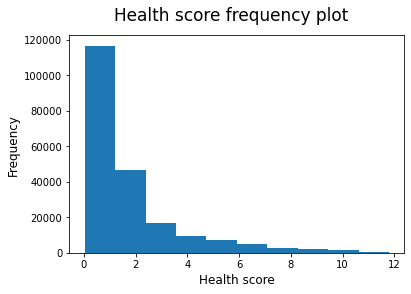

In [15]:
# distribution of "health" in the dataset
fig, ax = plt.subplots()
ax.set_xlabel('Health score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
fig.suptitle("Health score frequency plot", fontsize=17)
data_person_all["health"].hist(ax=ax)
ax.grid(False)

# Step 3: Preliminary data analysis

## Explore data house-health relation of boolian variables
In following four figures we present the relation between four house variables and health variables. The habitant of the house were quesioned whether the house is in need for a certain repair. They could either answer yes or no to these questions. Slight difference between these to groups is observed. One can see that in most of the cases house with need for a repair (blue bars) exhibit slightly lower values of health score. One has to have in mind that the distribution of health score is imbalanced across the population since most of the population is healthy so even a slight difference in health score could be important. In further analysis we will try to answer whether this difference is statisticaly significant. Interestignly it seems that people in badly maintaned houses seems to be less depressed and nervous.

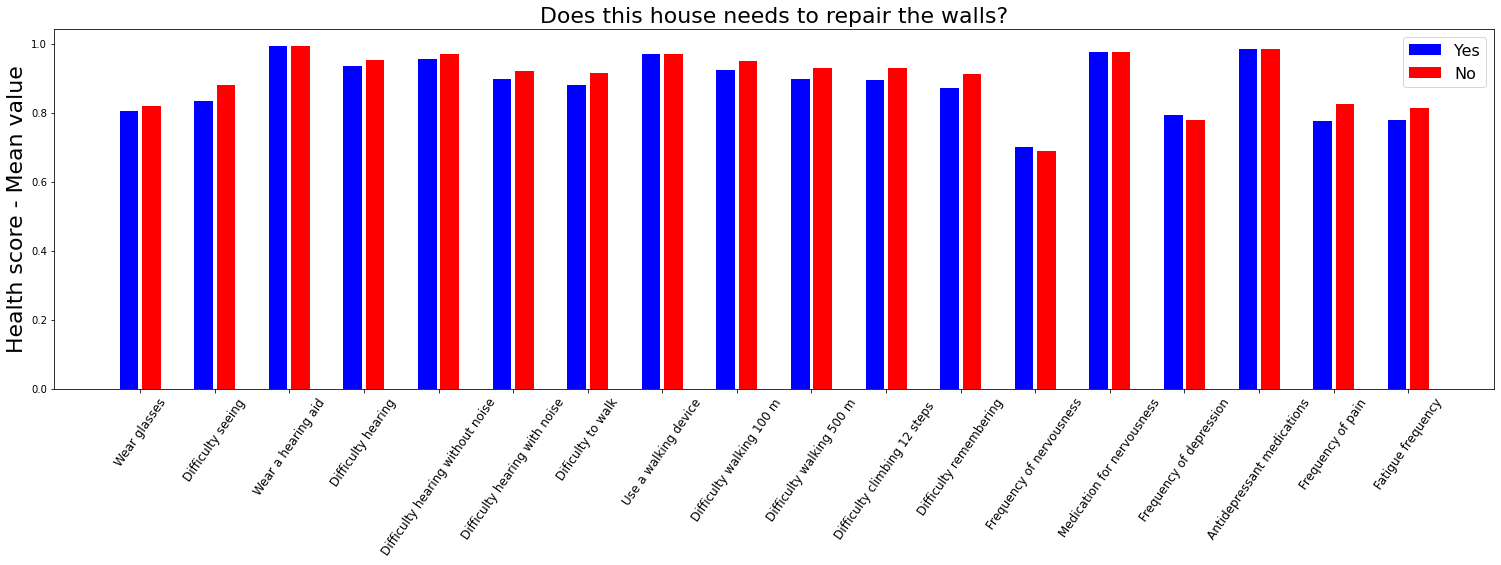

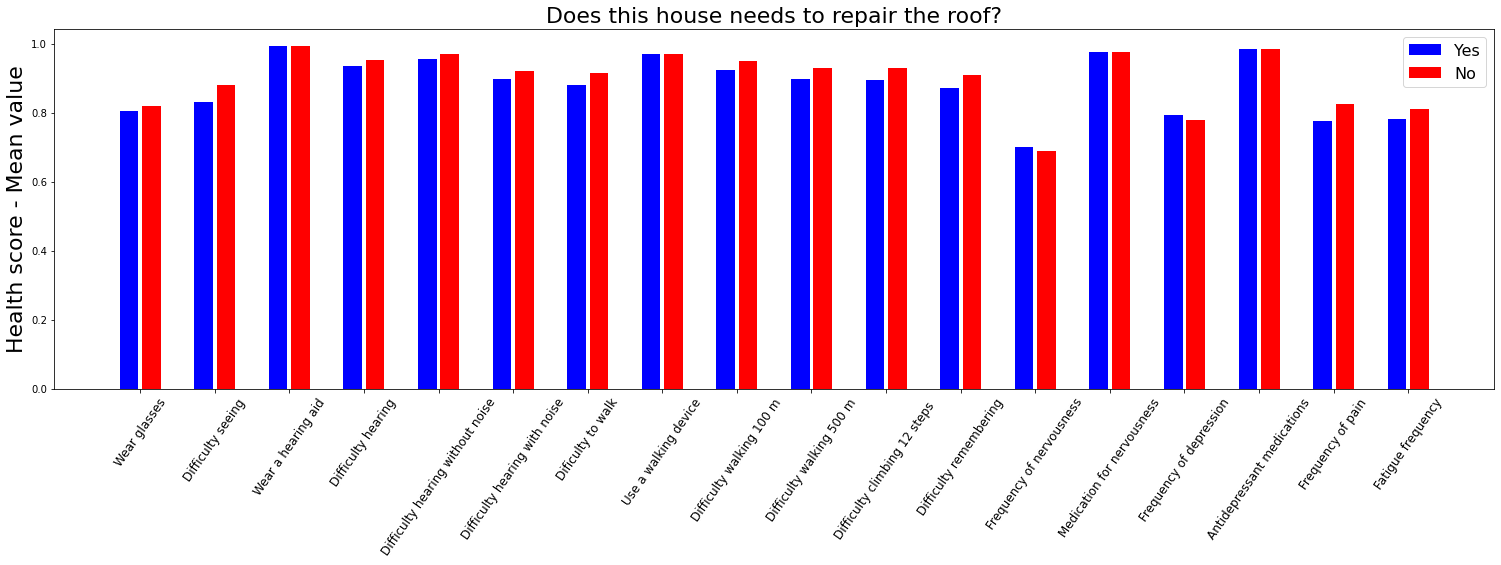

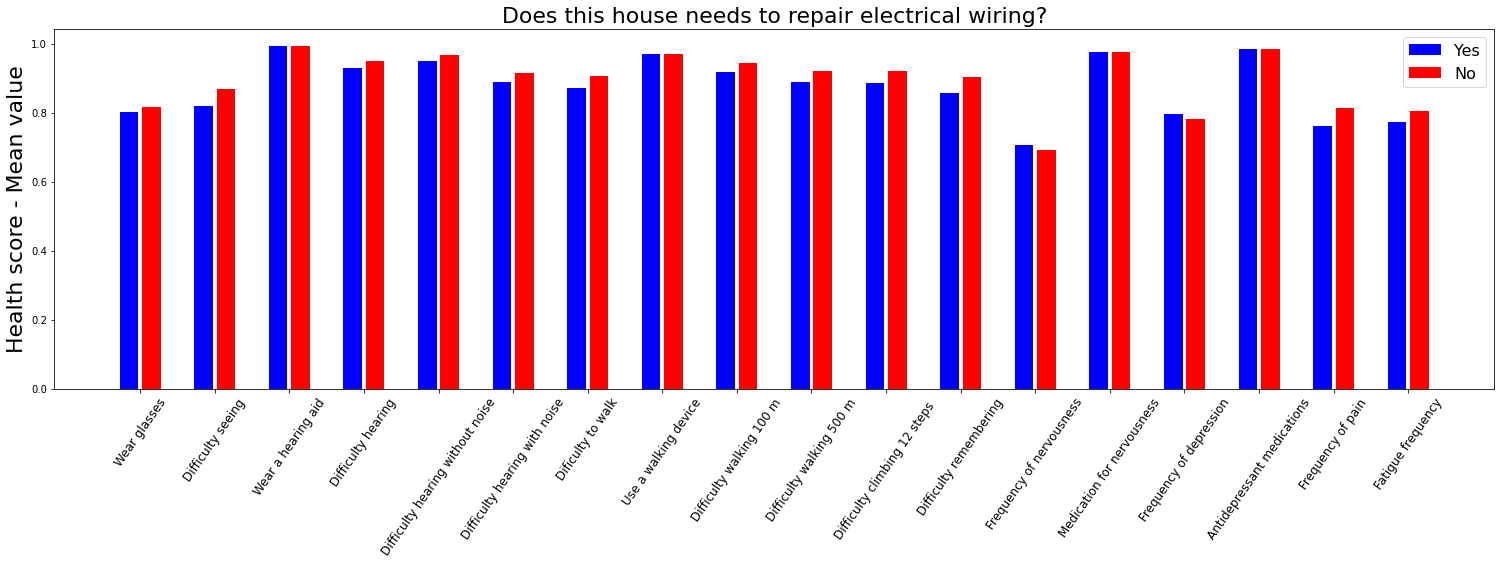

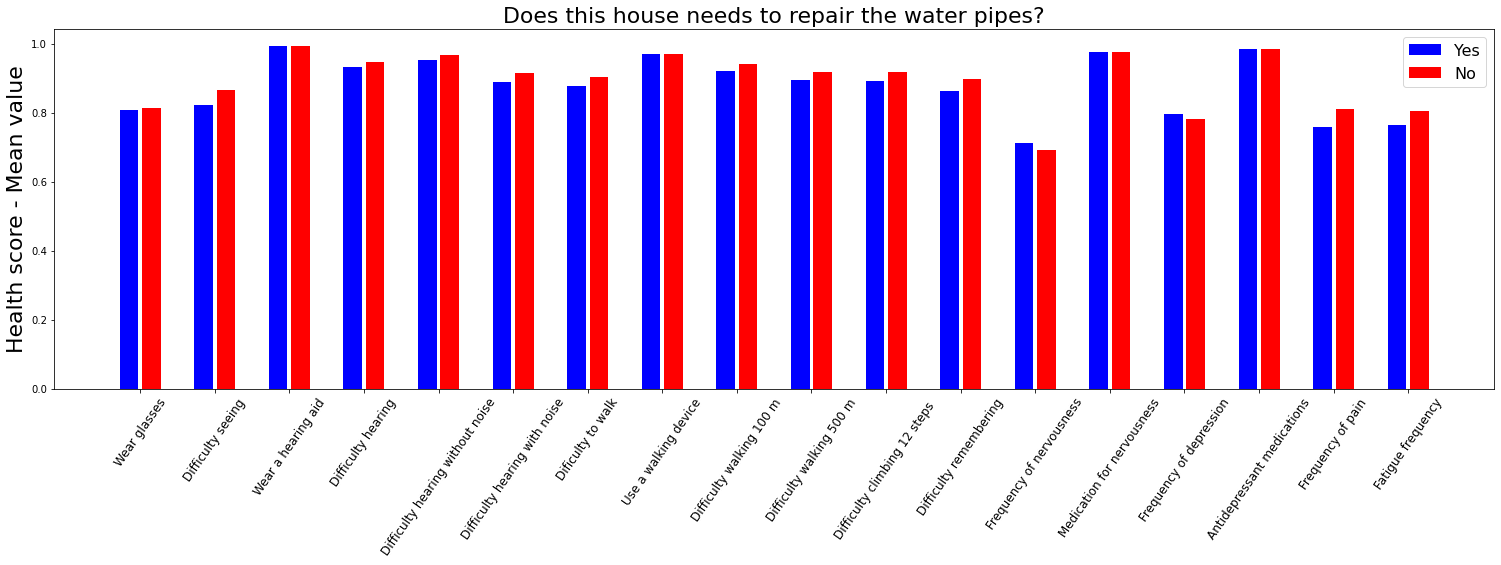

In [14]:
important_house_var=['Repair_the_walls' , 'Repair_the_roof' ,'Repair_electrical_wiring' ,'Repair_the_water_pipes']
health_var_txt=[x.replace('_',' ') for x in health_var ]

for house_item in important_house_var:
    mask=data_person_all[house_item]==1
    data_yes=data_person_all[mask]
    data_no=data_person_all[~mask]

    datay=data_yes[health_var].mean().values
    datax=data_no[health_var].mean().values

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_axes([0,0,1,1])
    
    x = np.arange(len(health_var))  # the label locations
    width = 0.3  # the width of the bars

    for item in health_var:
        ax.bar(x - width/2, datay, color = 'b', width = 0.25)
        ax.bar(x + width/2, datax, color = 'r', width = 0.25)
        ax.set_xticks(x)
        ax.set_xticklabels(health_var_txt,rotation='55',fontsize=12)
        ax.legend(labels=['Yes', 'No'],fontsize=16)
    plt.title('Does this house needs to '+house_item.replace('_',' ').lower()+'?',fontsize=22)
    plt.ylabel('Health score - Mean value',fontsize=22)

    

## Building materials vs Health

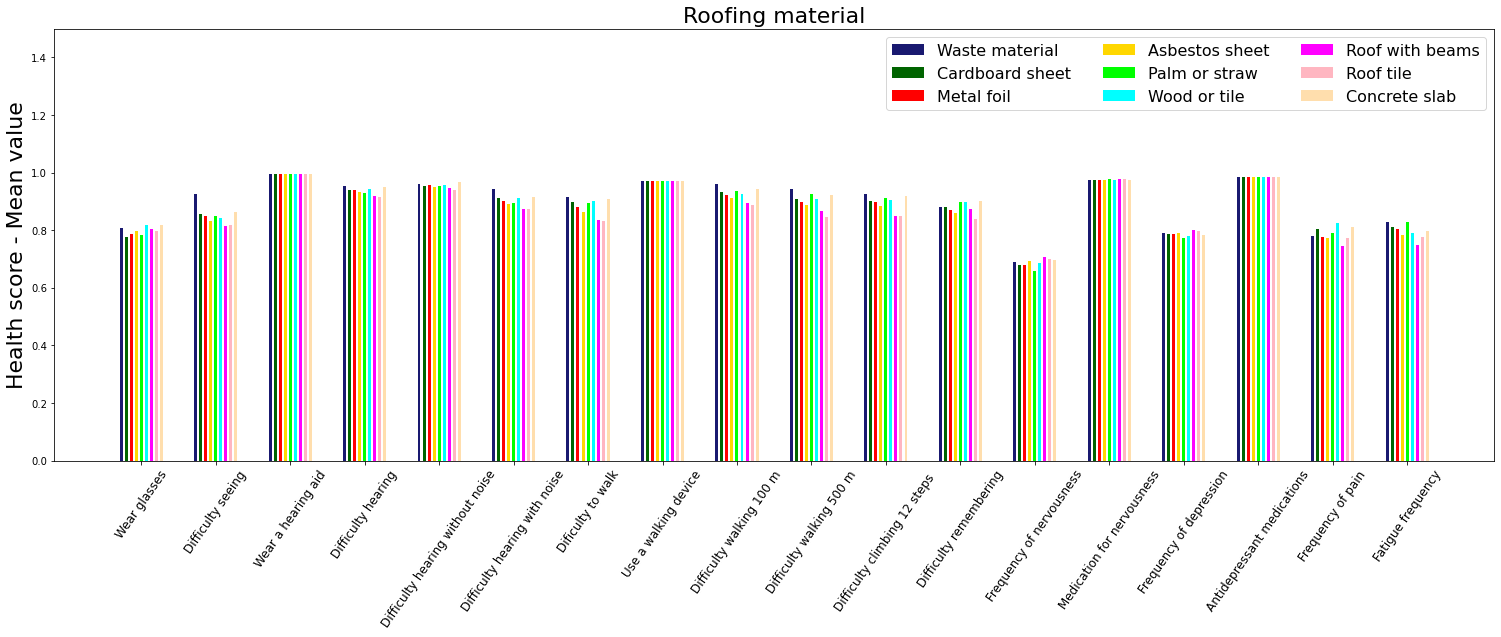

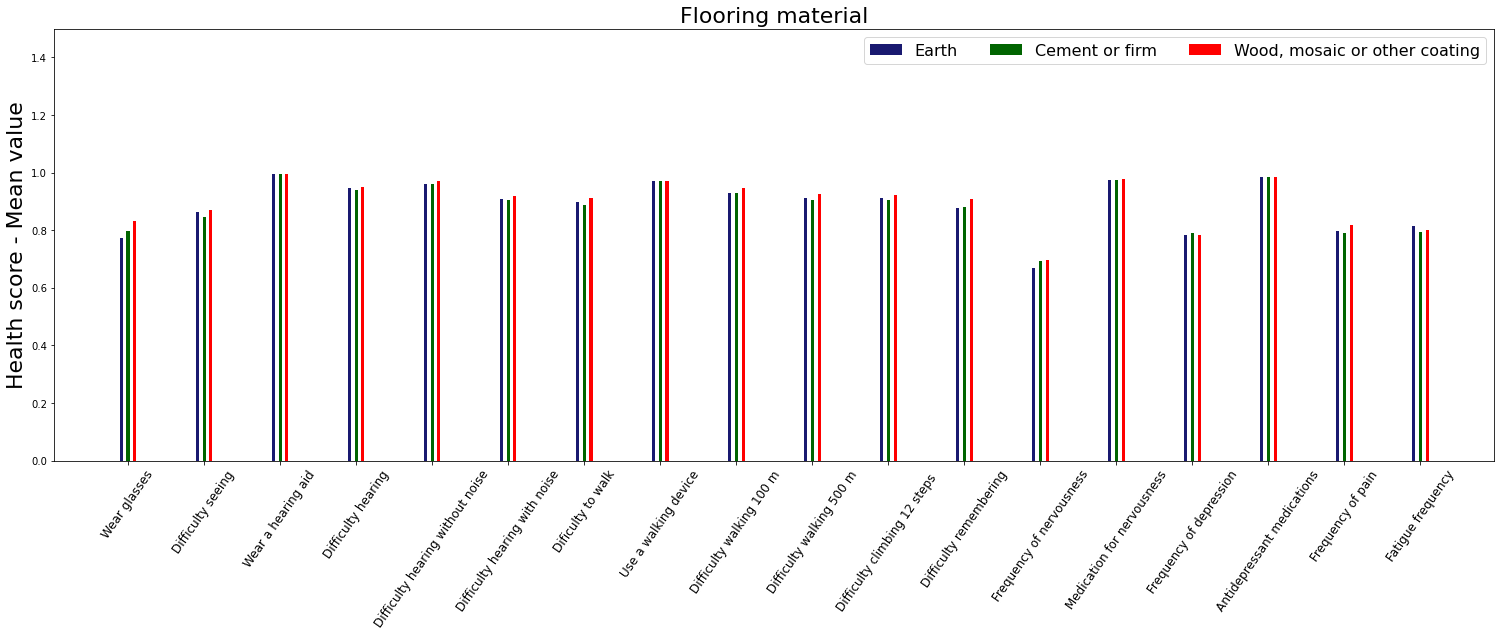

In [15]:
house_material=['Roofing_material','Flooring_material']
mat = [None] *2
mat[0]=['Waste material' ,'Cardboard sheet' ,'Metal foil','Asbestos sheet' ,'Palm or straw' ,'Wood or tile ','Roof with beams', 'Roof tile', 'Concrete slab' ]
mat[1]=['Earth', 'Cement or firm', 'Wood, mosaic or other coating']

for index_global,house_item in enumerate(house_material):
    answers=sorted(data_person_all[house_item].value_counts().index)
    len_answers=num=len(answers)
    
    data = [None] * len_answers
    for index,item in enumerate(answers):
        data[index]=data_person_all[data_person_all[house_item]==answers[index]][health_var].mean()
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_axes([0,0,1,1])
    
    x = np.arange(len(health_var))  # the label locations
    width = 0.06  # the width of the bars
    width_vector=np.linspace(start=-width*len_answers/2, stop=width*len_answers/2,num=len_answers )
    color_list=['#191970', '#006400', '#ff0000', '#ffd700', '#00ff00' ,'#00ffff','#ff00ff' ,'#ffb6c1','#ffdead']
    
    for item in health_var:
        for index,wid in enumerate(width_vector):
            ax.bar(x + wid, data[index], width = 0.04,color=color_list[index])
        ax.set_xticks(x)
        ax.set_xticklabels(health_var_txt,rotation='55',fontsize=12)
        ax.legend(labels=mat[index_global],fontsize=16,ncol=3)
    plt.ylim(0,1.5)
    plt.title(house_item.replace('_',' '),fontsize=22)
    plt.ylabel('Health score - Mean value',fontsize=22)


## Age of house vs health

Text(0, 0.5, 'Total health score - Mean ')

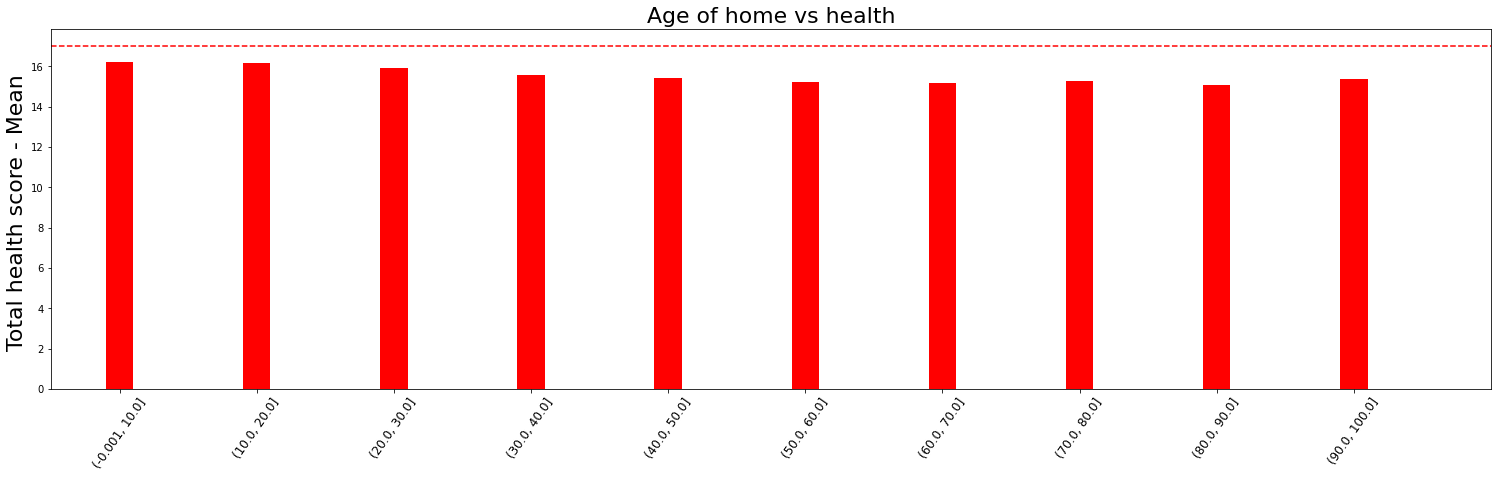

In [16]:
data_person_all['Age_home_cat']=pd.cut(data_person_all['Age_of_the_home'], bins=[0,10,20,30,40,50,60,70,80,90,100], include_lowest=True)
answers=sorted(data_person_all['Age_home_cat'].value_counts().index)
len_answers=len(answers)
means = [None] *len_answers
for index,item in enumerate(answers):
    means[index]=data_person_all[data_person_all['Age_home_cat']==item].apply(lambda x: sum([x[i] for i in health_var]), axis=1).mean()

fig= plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])    
x = np.arange(len_answers)  # the label locations
width = 0.3  # the width of the bars

ax.bar(x, means, color = 'r', width = 0.2)
plt.hlines(17,-0.5,10,linestyle = '--',color='r')
plt.xlim(-0.5,10)
ax.set_xticks(x)
ax.set_xticklabels(answers,rotation='55',fontsize=12)

plt.title('Age of home vs health',fontsize=22)
plt.ylabel('Total health score - Mean ',fontsize=22)


## Cell phone availability vs health

Text(0, 0.5, 'Health score - Mean value')

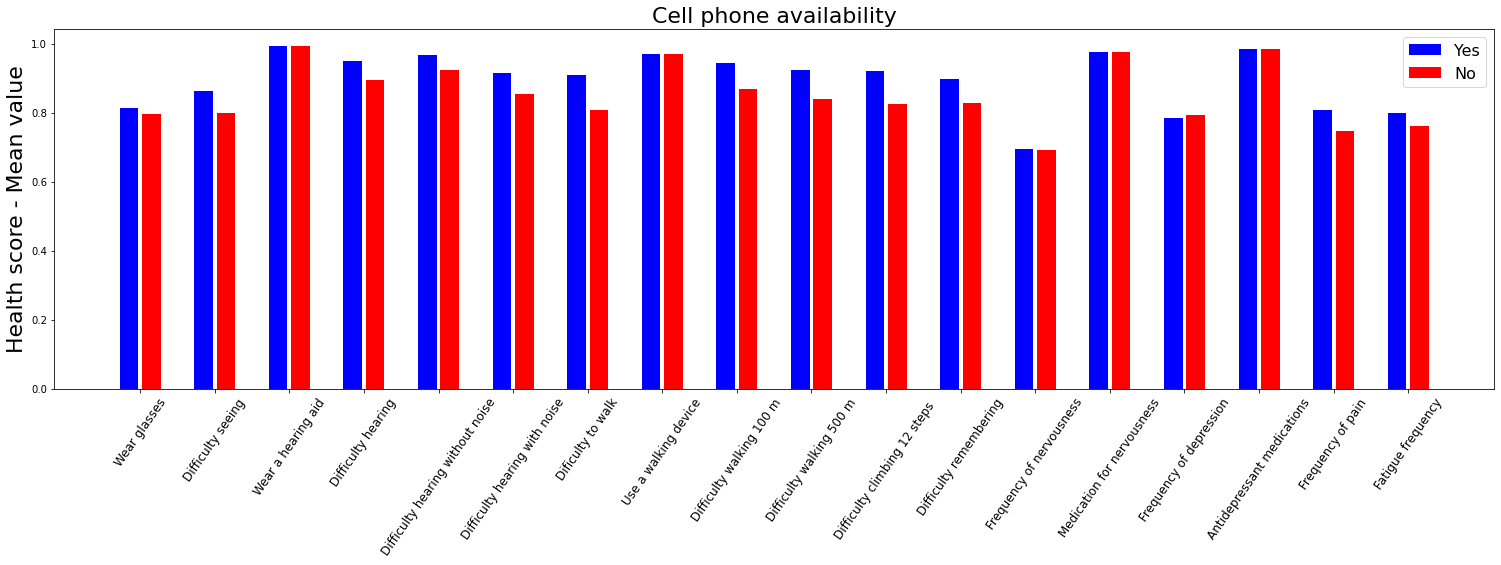

In [17]:
mask=data_person_all['Cell_phone_availability']==1
data_yes=data_person_all[mask]
data_no=data_person_all[~mask]

datay=data_yes[health_var].mean().values
datax=data_no[health_var].mean().values

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
    
x = np.arange(len(health_var))  # the label locations
width = 0.3  # the width of the bars

for item in health_var:
        ax.bar(x - width/2, datay, color = 'b', width = 0.25)
        ax.bar(x + width/2, datax, color = 'r', width = 0.25)
        ax.set_xticks(x)
        ax.set_xticklabels(health_var_txt,rotation='55',fontsize=12)
        ax.legend(labels=['Yes', 'No'],fontsize=16)
plt.title('Cell phone availability',fontsize=22)
plt.ylabel('Health score - Mean value',fontsize=22)

## Age of person vs health

Text(0, 0.5, 'Total health score - Mean ')

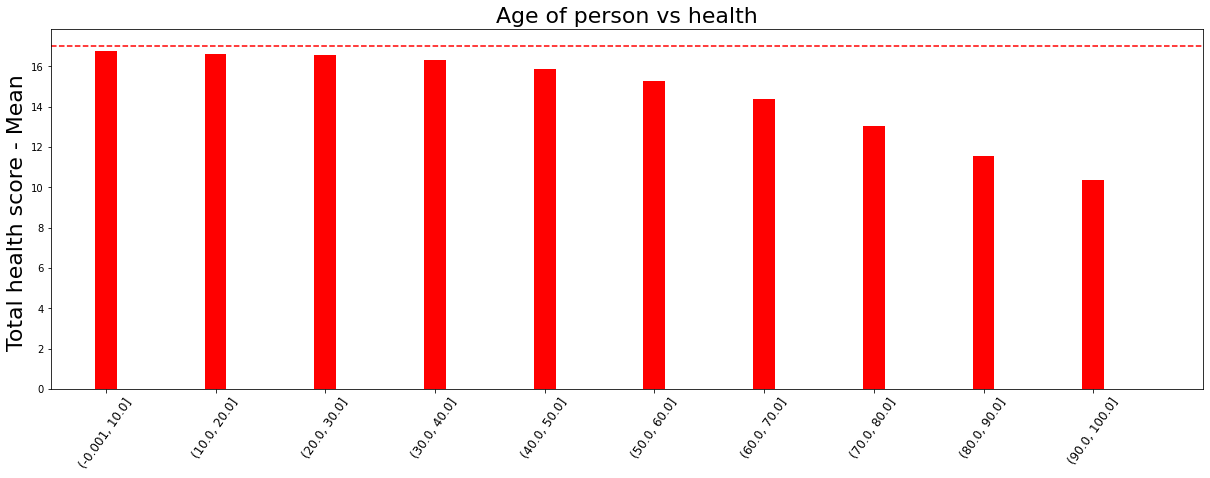

In [18]:
data_person_all['Age_cat']=pd.cut(data_person_all['Age'], bins=[0,10,20,30,40,50,60,70,80,90,100], include_lowest=True)
answers=sorted(data_person_all['Age_cat'].value_counts().index)
len_answers=len(answers)
means = [None] *len_answers
for index,item in enumerate(answers):
    means[index]=data_person_all[data_person_all['Age_cat']==item].apply(lambda x: sum([x[i] for i in health_var]), axis=1).mean()

fig= plt.figure(figsize=(16,5))
ax = fig.add_axes([0,0,1,1])    
x = np.arange(len_answers)  # the label locations
width = 0.3  # the width of the bars

ax.bar(x, means, color = 'r', width = 0.2)
plt.hlines(17,-0.5,10,linestyle = '--',color='r')
plt.xlim(-0.5,10)
ax.set_xticks(x)
ax.set_xticklabels(answers,rotation='55',fontsize=12)

plt.title('Age of person vs health',fontsize=22)
plt.ylabel('Total health score - Mean ',fontsize=22)


# Step 4: Linear Regression

### Fill response variables

In [19]:
data_person_all["health"].describe()

count    208140.000000
mean         16.055419
std           1.827860
min           6.205251
25%          15.885111
50%          16.972398
75%          16.972398
max          17.964452
Name: health, dtype: float64

In [20]:
# To run for all health_var or for health score
response='health'

### Pearson correlation
In order to limit the number of analyzed variables and to select the most important features, we calculate Person correlation coefficient. 

In [21]:
health_var.append('health')
covariates=list(data_person_all.columns)
covariates = [x for x in covariates if not x in health_var]

In [22]:
pearson_result=data_person_all[covariates].corrwith(data_person_all['health'], axis=0, method='pearson')
pearson_result=pearson_result.reindex(pearson_result.abs().sort_values(ascending=False).index)
#for val in pearson_result.items():
    #print(val)
covariates_top=pearson_result.index[0:25];

### Fill model with all variables

In [23]:
model='~'
cat_list=['Relationship','Type_of_home_ownership', 'Flooring_material', 'Roofing_material', 'Socioeconomic' ,'Location_size', 'Fuel_type']

for index,item in enumerate(covariates_top):
    if item not in data_house.columns:
        continue
    if index<1:
        model=model+item
    else:
        if data_person_all[item].value_counts().count()==2 or item in cat_list:
            model=model+'+'+'C('+item+')'
        else:
            model=model+'+'+item
            # Standardize the countinuous variables
            data_person_all[item] = (data_person_all[item] - data_person_all[item].mean())/data_person_all[item].std()
                
model

'~+Age_of_the_home+C(Cell_phone_availability)+C(Computer_availability)+C(Internet_availability)+C(Repair_the_walls)+C(Repair_the_roof)+C(Type_of_home_ownership)+C(Availability_of_own_car)+C(Repair_electrical_wiring)+C(Garage_space)+C(Flooring_material)+C(Repair_the_water_pipes)+C(Roofing_material)+C(Repair_drain_pipes)+C(Pay_TV_service_availability)+Number_of_energy_saving_bulbs+C(Socioeconomic)'

In [24]:
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(1950)
mod= smf.ols(formula=response+model, data=data_person_all,missing='raise')
res = mod.fit()
res.summary();

In [25]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

In [26]:
#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

# in this case, we index starting from the first element, not to plot the intercept

# we will use standard errors, instead of CIs
# two standard errors approximate the CIs (you can actually see in the summary table that
# +/2 SI is equivalent to the CIs)

# Edit l2
l2=[x.replace('_',' ') for x in l2 ]

## Regression resluts
We plot the resulsting coefficents with intervals showing +-2 standard errors. The coefficent are sorted in the descending order.

Text(0.5, 0, 'Regression coefficent')

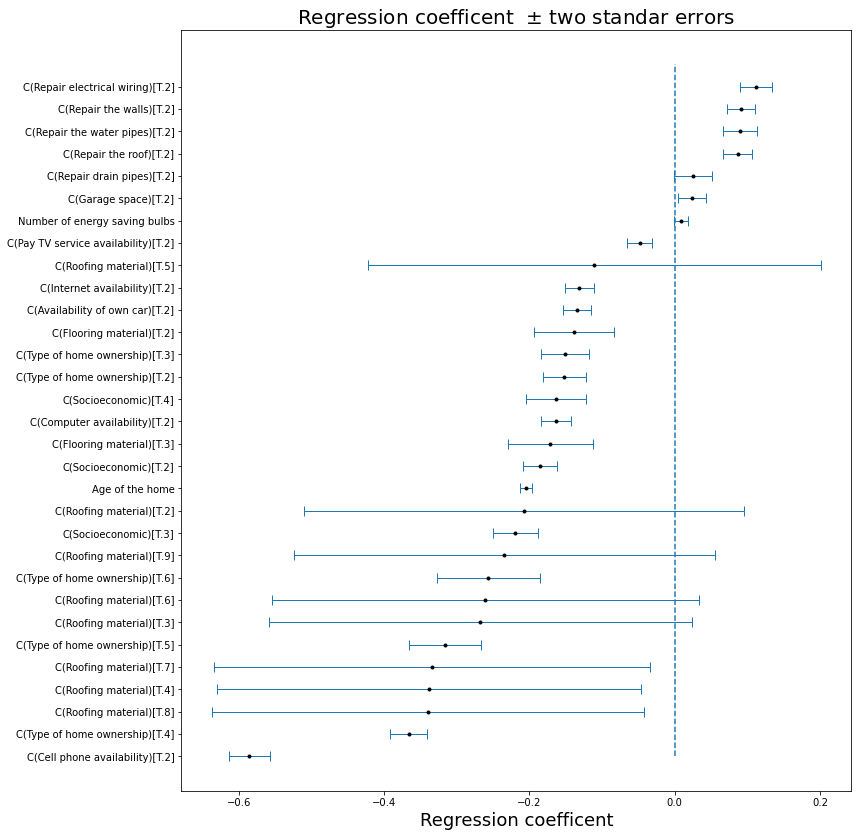

In [27]:
# Plotting
plt.figure(figsize=(12,14))
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);
plt.title('Regression coefficent  $\pm$ two standar errors',fontsize=20)
plt.xlabel('Regression coefficent',fontsize=18)